In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

%matplotlib inline

## read in the data

In [2]:
data = pd.read_csv('youtube-comments.csv')

In [3]:
data.head()

,comment,troll,title,views,dislikes,commentCount,likes,replies,id
0,"What a lucky guy, got celebrated birthday on c...",0,Nothing Compares 2 U (Live in LA w/ James Corden),469414,263,1123,19392,0,mak_Cu9Wl6w
1,Love it﻿,0,Nothing Compares 2 U (Live in LA w/ James Corden),469414,263,1123,19392,0,mak_Cu9Wl6w
2,no americans even knew who corden was several ...,0,Nothing Compares 2 U (Live in LA w/ James Corden),469414,263,1123,19392,0,mak_Cu9Wl6w
3,my birthday was the 22nd as well and we both s...,0,Nothing Compares 2 U (Live in LA w/ James Corden),469414,263,1123,19392,0,mak_Cu9Wl6w
4,OMG IM CRYING﻿,0,Nothing Compares 2 U (Live in LA w/ James Corden),469414,263,1123,19392,0,mak_Cu9Wl6w


## cleaning the text

In [4]:
def cleaner(text):
    '''Function to clean the text data and prep for further analysis'''
    stops = set(stopwords.words("english"))     # Creating a set of Stopwords
    p_stemmer = PorterStemmer()                 # Creating the stemmer model
    text = re.sub("[^a-zA-Z]"," ",text)          # Removes punctuation
    text = text.split()                          # Splits the data into individual words 
    text = [w for w in text if not w in stops]   # Removes stopwords
    text = [p_stemmer.stem(i) for i in text]     # Stemming (reducing words to their root)
    return ' '.join(text)

In [5]:
data['clean'] = data['comment'].apply(cleaner)

In [6]:
data.head()

,comment,troll,title,views,dislikes,commentCount,likes,replies,id,clean
0,"What a lucky guy, got celebrated birthday on c...",0,Nothing Compares 2 U (Live in LA w/ James Corden),469414,263,1123,19392,0,mak_Cu9Wl6w,What lucki guy got celebr birthday concert bil...
1,Love it﻿,0,Nothing Compares 2 U (Live in LA w/ James Corden),469414,263,1123,19392,0,mak_Cu9Wl6w,Love
2,no americans even knew who corden was several ...,0,Nothing Compares 2 U (Live in LA w/ James Corden),469414,263,1123,19392,0,mak_Cu9Wl6w,american even knew corden sever year ago
3,my birthday was the 22nd as well and we both s...,0,Nothing Compares 2 U (Live in LA w/ James Corden),469414,263,1123,19392,0,mak_Cu9Wl6w,birthday nd well support west ham
4,OMG IM CRYING﻿,0,Nothing Compares 2 U (Live in LA w/ James Corden),469414,263,1123,19392,0,mak_Cu9Wl6w,OMG IM CRi


## using tf-idf to convert the clean comments to a matrix of freq's

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing

In [8]:
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5,
                                 stop_words='english')
X = vectorizer.fit_transform(data.clean)

## creating labels

In [9]:
le = preprocessing.LabelEncoder()
le.fit(data.troll.values)
Y = le.transform(data.troll.values) 

## defining a classifier function

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import log_loss

def model_rfc(X, Y):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=.80)
    clf = RandomForestClassifier(n_estimators=30)
    clf.fit(X_train, y_train)
    clf_probs = clf.predict_proba(X_test)
    score = log_loss(y_test, clf_probs)
    print(score)
    plt.bar(range(X.shape[1]), clf.feature_importances_)

## dimensionality reduction

tf-idf vectorizer gives around 5500 words (columns) and that's more than the number of rows, and since most words are redundant anyway it is important to reduce the dimensionality of the problem

### trying PCA

In [11]:
from sklearn import decomposition

In [12]:
%%time

pca = decomposition.PCA(n_components=100)
pca.fit(X.toarray())
#data_pca = pca.transform(X)

Wall time: 53.8 s


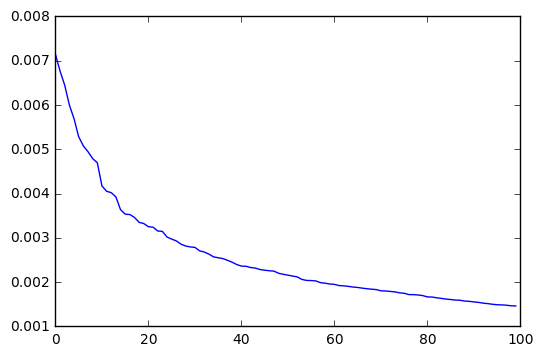

In [13]:
plt.plot(pca.explained_variance_ratio_)

In [14]:
%%time

pca = decomposition.PCA(n_components=20)
pca.fit(X.toarray())
X_pca = pca.transform(X.toarray())

Wall time: 54.9 s


## classifying using the result of PCA

0.510407608197


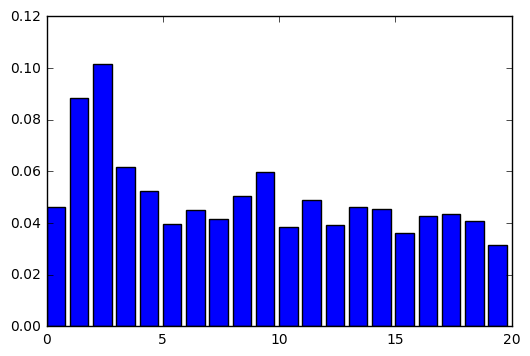

In [22]:
model_rfc(X_pca, Y)

## creating new features based on the length of the comment etc

In [49]:
def bad_word_counter(text):
    bad_words = pd.read_csv('google_badlist.txt', header=None).values
    return len([w for w in text.split() if w in bad_words])

In [51]:
def transform(documents):
    ## some handcrafted features!
    n_words = [len(c.split()) for c in documents]
    n_chars = [len(c) for c in documents]
    # number of uppercase words
    allcaps = [np.sum([w.isupper() for w in comment.split()])
           for comment in documents]
    # longest word
    max_word_len = [np.max([len(w) for w in c.split()]) for c in documents]
    # average word length
    mean_word_len = [np.mean([len(w) for w in c.split()])
                                        for c in documents]
    # number of google badwords:
    n_bad = [bad_word_counter(c) for c in documents]
    exclamation = [c.count("!") for c in documents]
    addressing = [c.count("@") for c in documents]
    spaces = [c.count(" ") for c in documents]

    allcaps_ratio = np.array(allcaps) / np.array(n_words, dtype=np.float)
    bad_ratio = np.array(n_bad) / np.array(n_words, dtype=np.float)

    return np.array([n_words, n_chars, allcaps, max_word_len,
        mean_word_len, exclamation, addressing, spaces,
        allcaps_ratio, n_bad, bad_ratio]).T

## classifying based on the features like the length of the comment etc

In [52]:
from sklearn.preprocessing import scale

1.08042613215


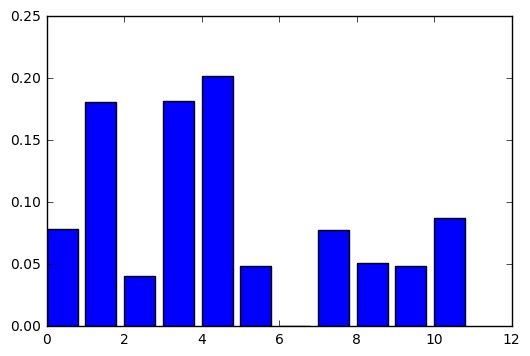

In [54]:
X_ext = scale(transform(data.comment), with_mean=False)
model_rfc(X_ext, Y)

## classifying based on generated features

0.537978035549


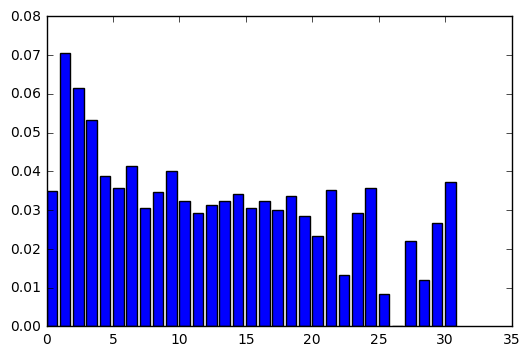

In [56]:
model_rfc(np.concatenate((X_pca, transform(data.comment)), axis=1), Y)